## Reading the input file
### The input file is a large set of names taken from:
https://github.com/karpathy/makemore/blob/master/names.txt

In [23]:
words = open("names.txt", "r").read().splitlines()

In [24]:
print("First ten words in the dataset:")
print(words[:10])
print("\nAmount of words in the dataset")
print(len(words))

First ten words in the dataset:
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']

Amount of words in the dataset
32033


## Lets find the rate at which each letter follows another letter in the dataset

### Note: We will also find the rate of which a letter will be the start or end to a word

In [25]:
import torch

### For ease of use, we will make a 2D array to represent the word counts

In [26]:
countsArray = torch.zeros((27,27),dtype=torch.int32) + 1

In [27]:
#A list of all letters in the alphabet sorted from a-z
alphabet = sorted(list(set("".join(words))))

stoi = {s:i+1 for i,s in enumerate(alphabet)}
stoi["."] = 0 # a special character to indiciate the start or end of a word
itos = {i:s for s,i in stoi.items()}


In [28]:
for word in words:
    chs = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        countsArray[ix1,ix2] += 1

In [29]:
import matplotlib.pyplot as plt

This figure represents the amount of times a specific two letter string is present in the input file.
The '.' character represents the start or end of a string


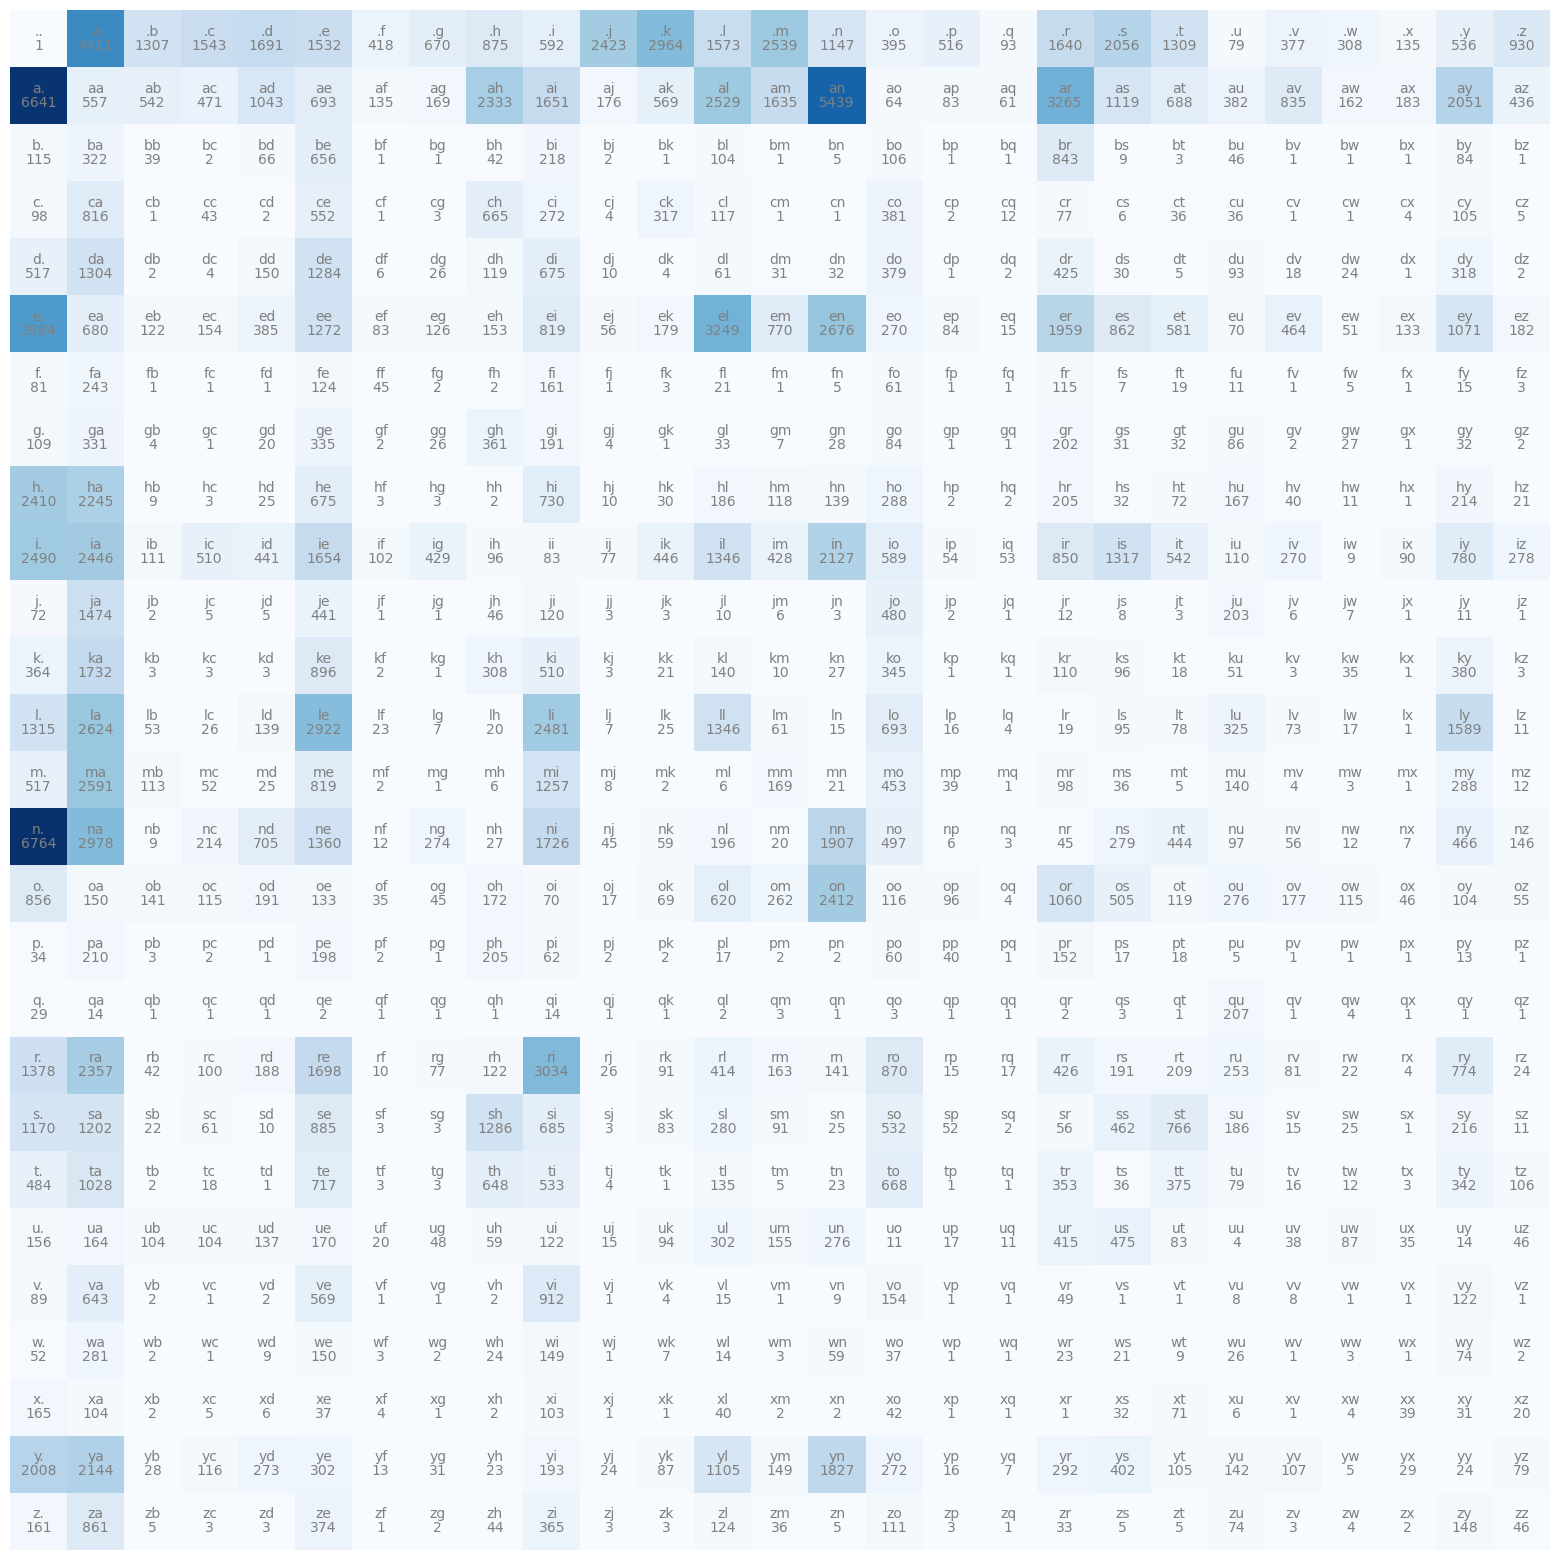

In [30]:
print("This figure represents the amount of times a specific two letter string is present in the input file.\nThe '.' character represents the start or end of a string")

plt.figure(figsize=(20,20))
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha="center", va="bottom", color="grey")
        plt.text(j,i, countsArray[i,j].item(), ha="center", va="top", color="grey")
plt.axis("off")
plt.imshow(countsArray, cmap="Blues")

### Lets create a probability distribution of these 2 character strings

In [31]:
distributions = countsArray.float()
distributions /= distributions.sum(1, keepdim=True)

In [32]:
print("Generated names:\n")
g = torch.Generator().manual_seed(2147483647)


for i in range(10):
    out = []
    ix = 0
    while True:
        p = distributions[ix]
        ix = torch.multinomial(countsArray[ix].float(), num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))

Generated names:

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


In [33]:
loglikelihood = 0
n=0
for word in words:
    chs = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = distributions[ix1, ix2]
        logprob = torch.log(prob)
        loglikelihood += logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print("Average loglikelihood: " + str(loglikelihood.item()/n))


Average loglikelihood: -2.4543562565199477


# Using ML to get the probability distributions

In [34]:
import torch.nn.functional as F

In [35]:
''' Create the training set '''
xs, ys = [], []

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
numberOfExamples = xs.nelement()


In [36]:
W = torch.randn((27,27), requires_grad=True)

In [39]:
''' Gradient descent '''
descents = []
losses = []
for k in range(100):

    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = (xenc @ W)
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(numberOfExamples), ys].log().mean()
    losses.append(loss.item())

    # Backward pass
    W.grad = None
    loss.backward()
    W.data -= 50 * W.grad

    descents.append(k)

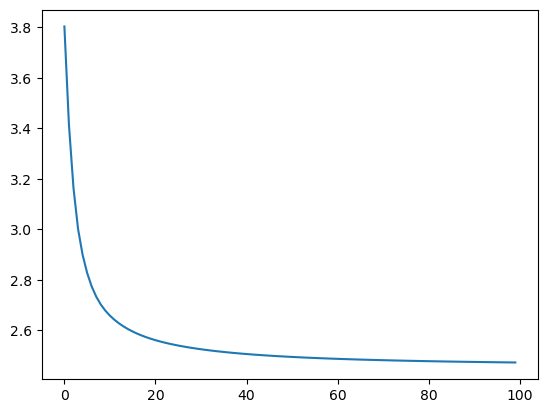

In [40]:
''' Plot the loss as a function of descents '''
plt.plot(descents, losses)

Same as the countsArray plot from before if converted into a probability distribution


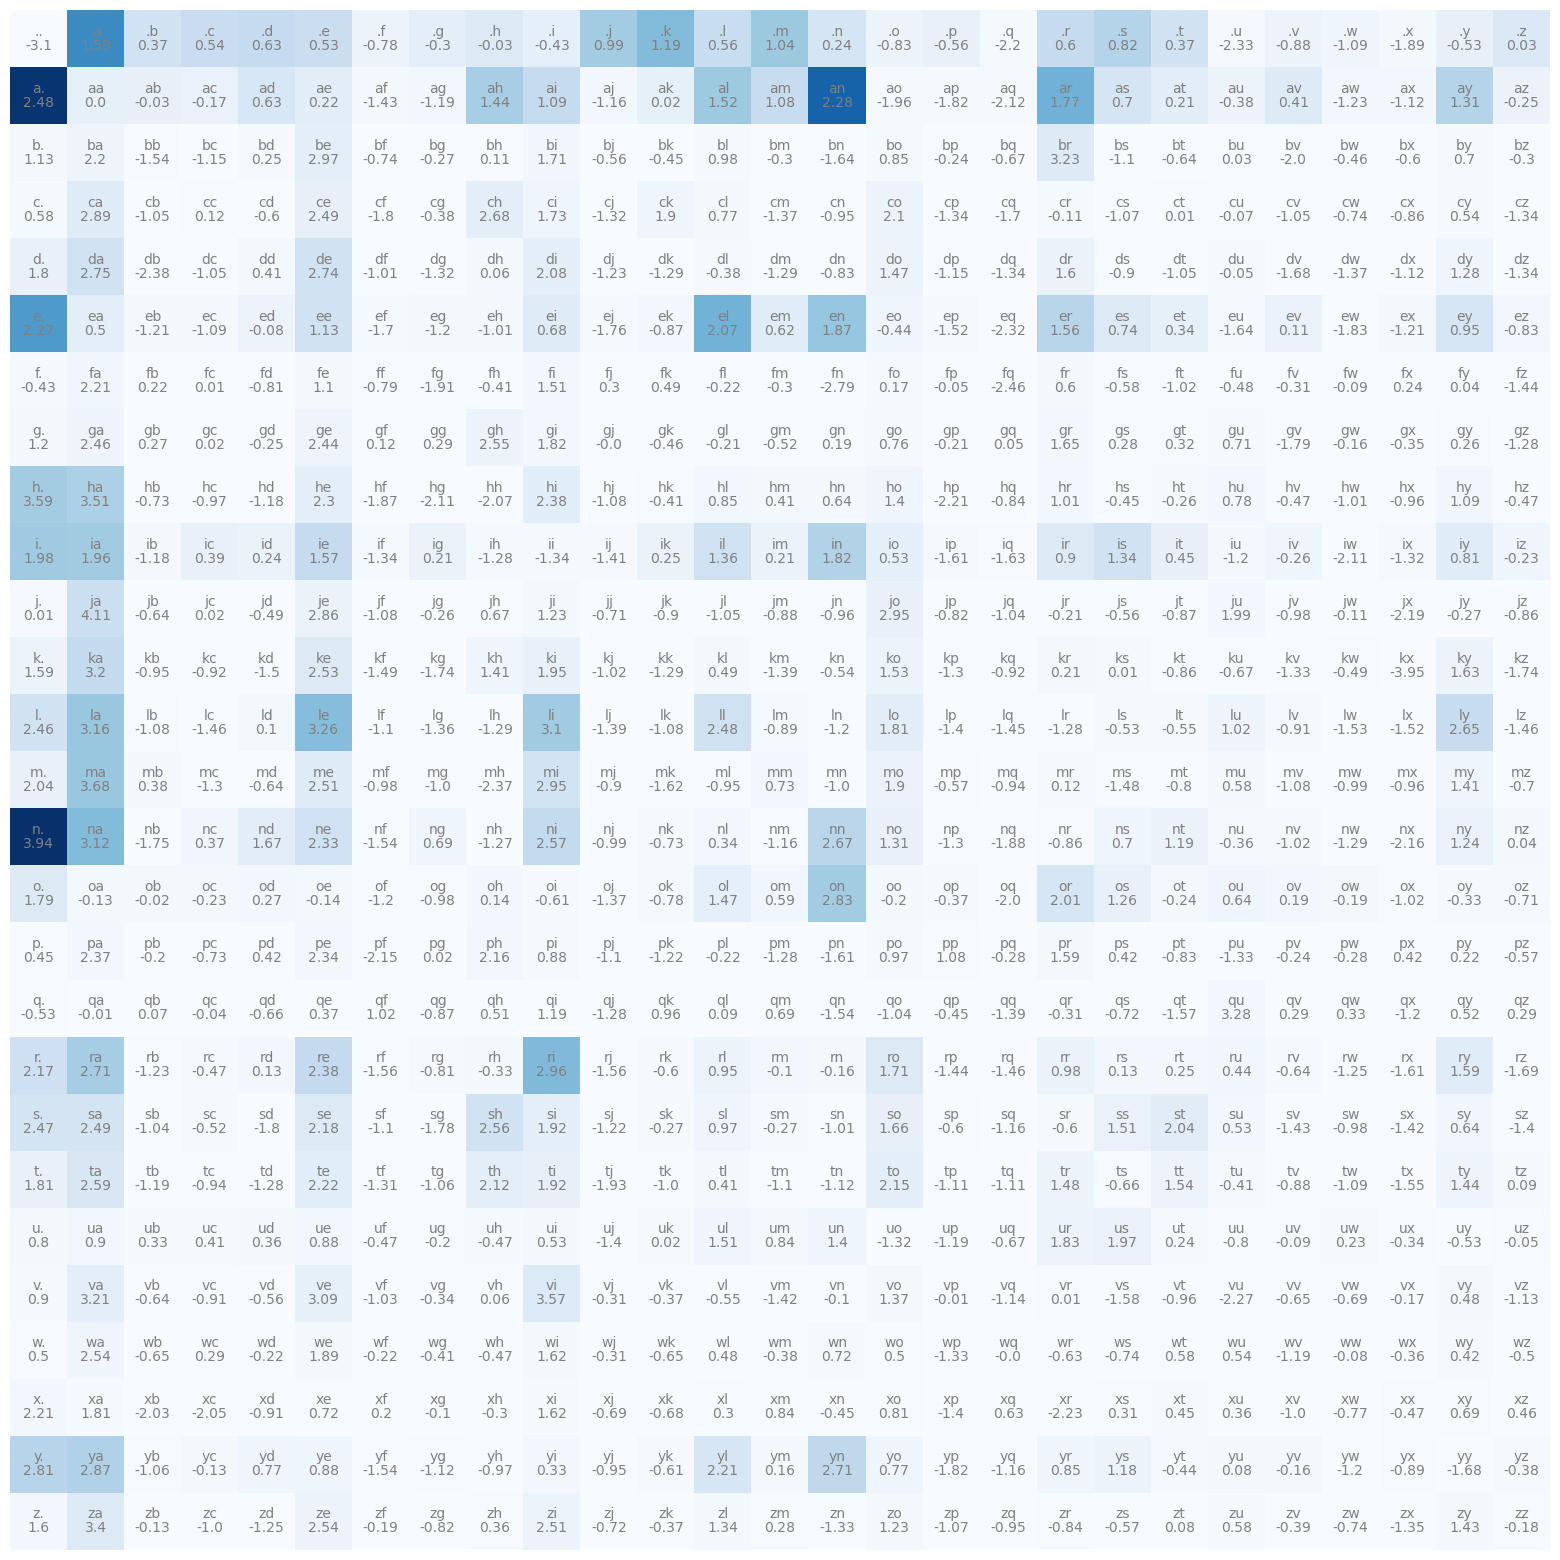

In [41]:
''' The probability distribution '''

print("Same as the countsArray plot from before if converted into a probability distribution")

plt.figure(figsize=(20,20))
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha="center", va="bottom", color="grey")
        plt.text(j,i, round(W[i,j].item(),2), ha="center", va="top", color="grey")
plt.axis("off")
plt.imshow(countsArray, cmap="Blues")

In [43]:
''' Get generated names '''
g = torch.Generator().manual_seed(2147483647)

for i in range(10):

    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W 
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    
    print("".join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
